In [3]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm.notebook import tqdm

In [4]:
from path_overlap import * 

In [5]:
num_dense, num_sparse = 5, 15
tot_units = num_dense + num_sparse
density = 1
num_layers = 3
MPG = multipartite_network(num_layers, num_dense, num_sparse, density)

In [6]:
pos = nx.multipartite_layout(MPG)

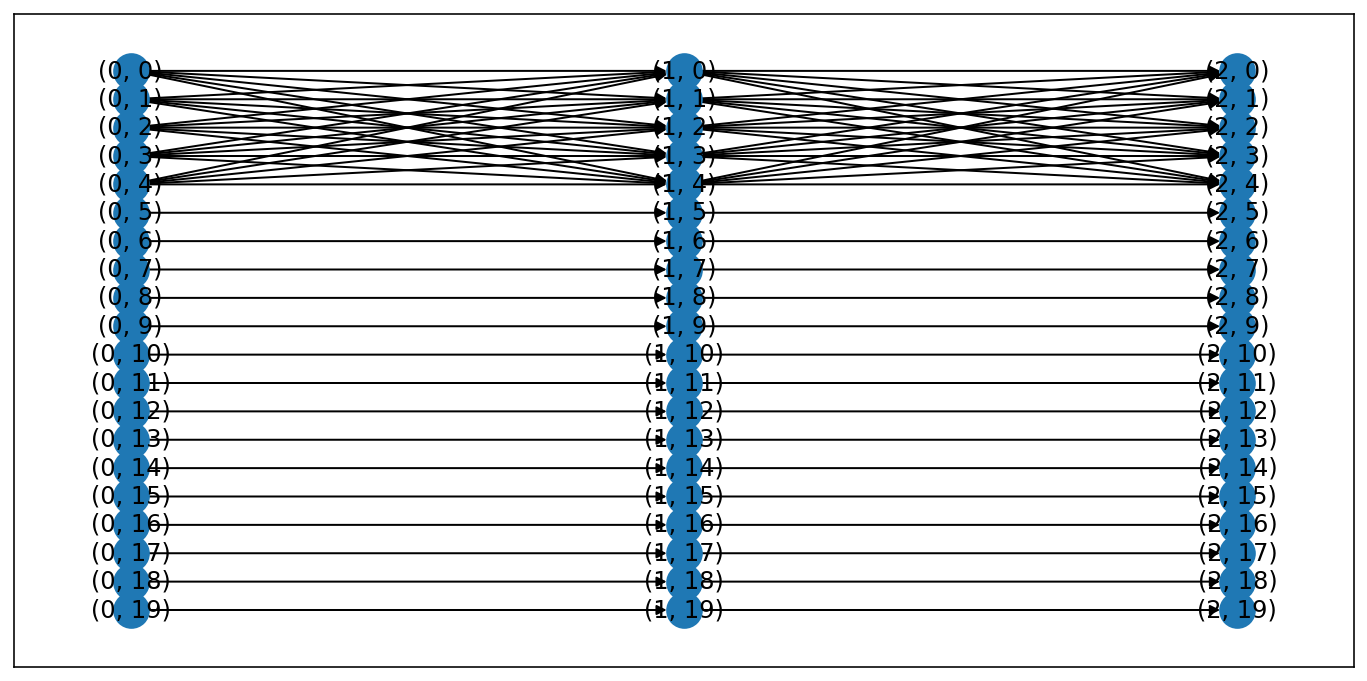

In [7]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(MPG, pos)

In [8]:
rew_MPG, counts = rewire_multipartite_network(MPG, tot_units, rewire_prob=.9, verbose=True, rewire_iters=100)

In [9]:
rew_pos = nx.multipartite_layout(rew_MPG)

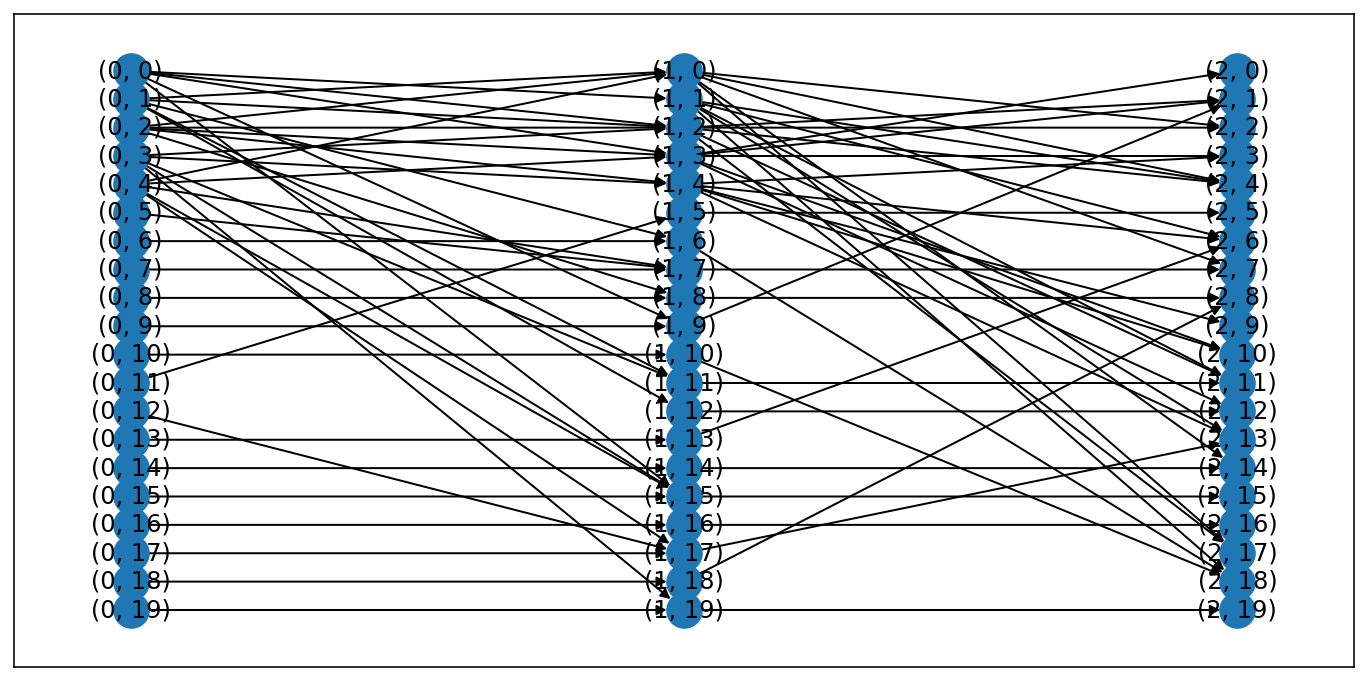

In [10]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(rew_MPG, pos)

In [9]:
from itertools import combinations, product
output_nodes = [(num_layers-1, x) for x in range(tot_units)]
input_nodes = [(0, x) for x in range(tot_units)]

paths = {}
for n, nn in product(input_nodes, output_nodes):
    paths[(n, nn)] = list(nx.all_simple_paths(MPG, n, nn));
    
rew_paths = {}
for n, nn in product(input_nodes, output_nodes):
    rew_paths[(n, nn)] = list(nx.all_simple_paths(rew_MPG, n, nn));

In [10]:
IG, rew_IG = MP_interference_graph(MPG, paths), MP_interference_graph(rew_MPG, rew_paths)

In [11]:
IG.number_of_edges(), rew_IG.number_of_edges()

(300, 2651)

376

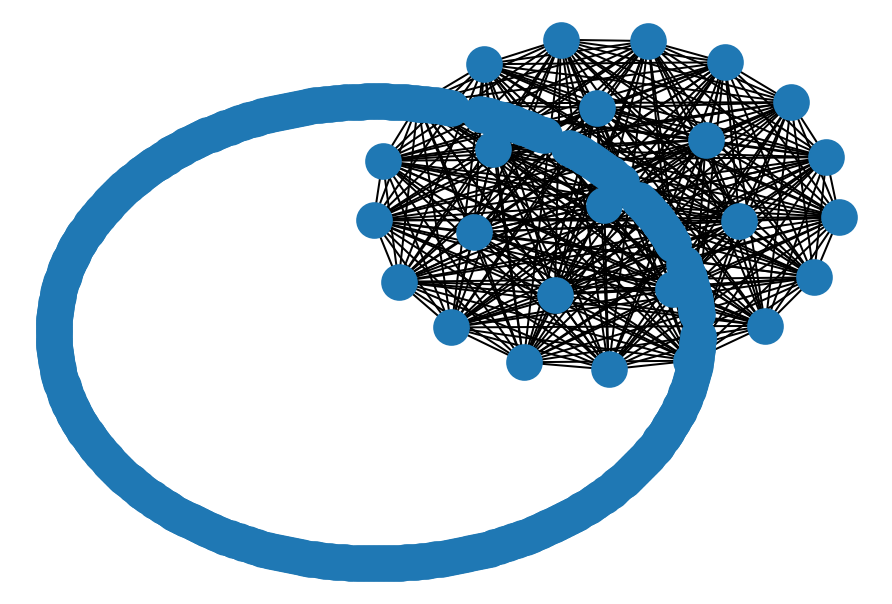

In [12]:
nx.draw_kamada_kawai(IG)
len(nx.maximal_independent_set(IG))

# Evolution of MIS as a function of rewiring

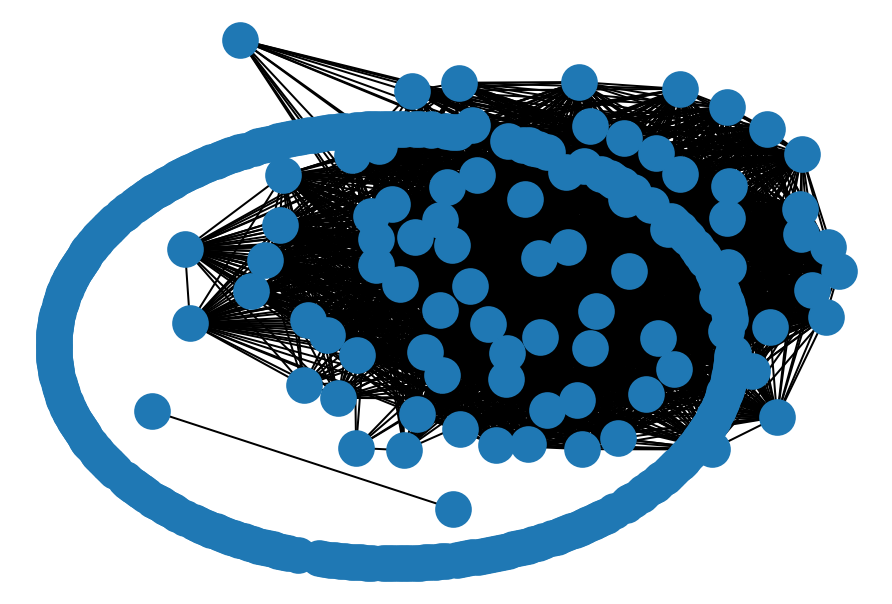

In [13]:
nx.draw_kamada_kawai(rew_IG)

In [91]:
num_iterations = 30
rw_it = 0.1
IG_dict = {}

num_dense, num_sparse = 5, 15
tot_units = num_dense + num_sparse
density = 1
counts = {}
range_num_layers = [2, 3, 4]
capacity = {}
independent_paths = {}

for nl in tqdm(range_num_layers):
    capacity[nl] = {}
    IG_dict[nl] = {}
    independent_paths[nl] = {}
    tMPG = multipartite_network(nl, num_dense, num_sparse, density)    
    IG_dict[nl][0], instant_paths = MP_interference_graph(tMPG);
    instant_rew_MPG = tMPG.copy()
    counts[nl] = [0]
    for it in tqdm(range(1, num_iterations)):
        rw_it_num = int(instant_rew_MPG.number_of_edges() * rw_it) 
        instant_rew_MPG, instant_counts = rewire_multipartite_network(
            instant_rew_MPG, tot_units, rewire_prob=1, rewire_iters=rw_it_num, verbose=True)
        counts[nl].append(counts[nl][-1]+instant_counts)
        IG_dict[nl][it], instant_paths = MP_interference_graph(instant_rew_MPG)
        capacity[nl][it]  = effective_capacity(instant_rew_MPG, instant_paths, sizes = [2,3], num_samples=4000)
        independent_paths[nl][it] = all_flows_MPG(instant_rew_MPG, instant_paths)

Text(0, 0.5, '|MIS|')

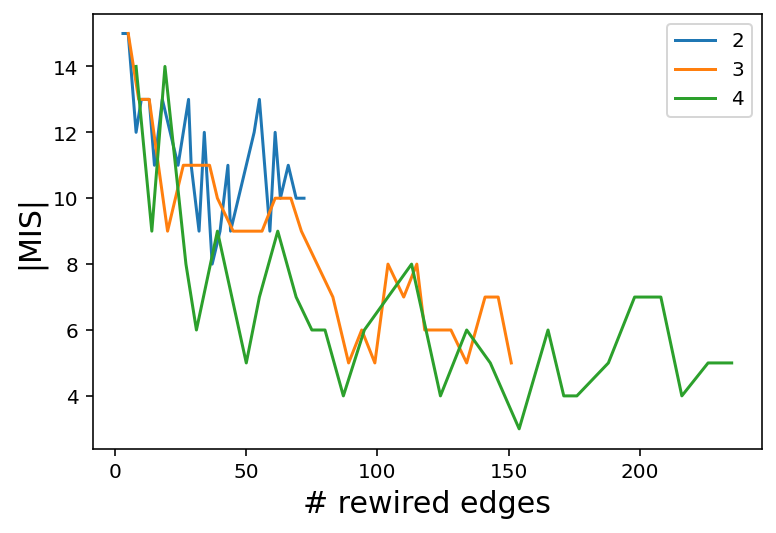

In [92]:
tot_interference = {}
for nl in range_num_layers:
    tot_interference[nl] = [len(nx.maximal_independent_set(nx.Graph(IG_dict[nl][x]))) for x in range(1, num_iterations)]
    plt.plot(counts[nl][1:], tot_interference[nl], label = nl)
plt.legend()
plt.xlabel('# rewired edges', fontsize=15)
plt.ylabel('|MIS|', fontsize=15)

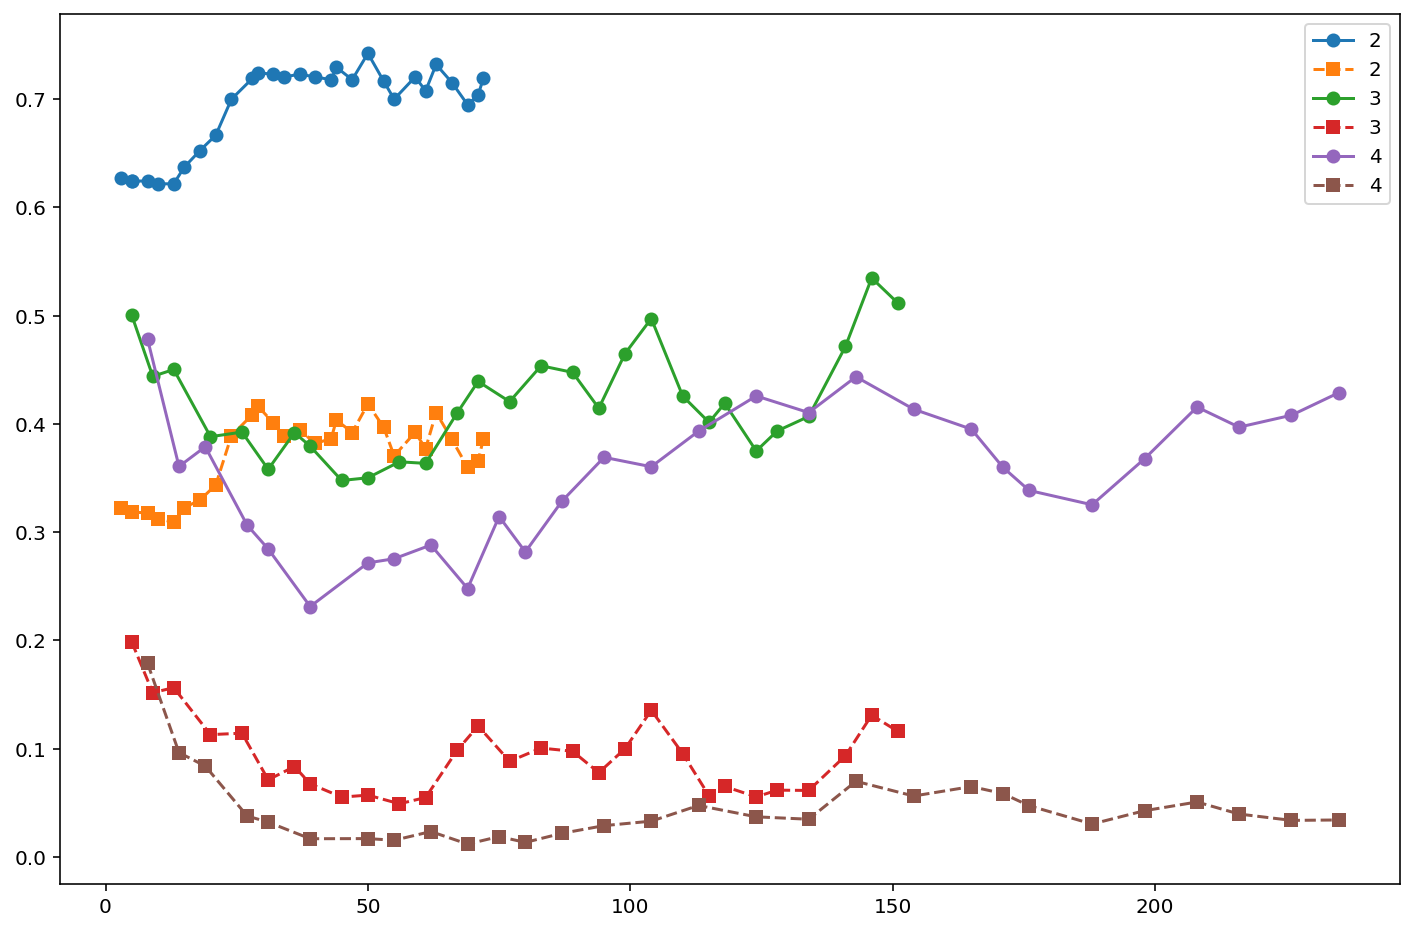

In [93]:
tot_capacity = {}
plt.figure(figsize=(12,8))

for nl in range_num_layers:
    tot_capacity[nl] = [1 - capacity[nl][x][2] for x in range(1,num_iterations)]
    plt.plot(counts[nl][1:], tot_capacity[nl], '-o', label = nl)
    tot_capacity[nl] = [1 - capacity[nl][x][3] for x in range(1,num_iterations)]
    plt.plot(counts[nl][1:], tot_capacity[nl], '--s', label = nl)
plt.legend()

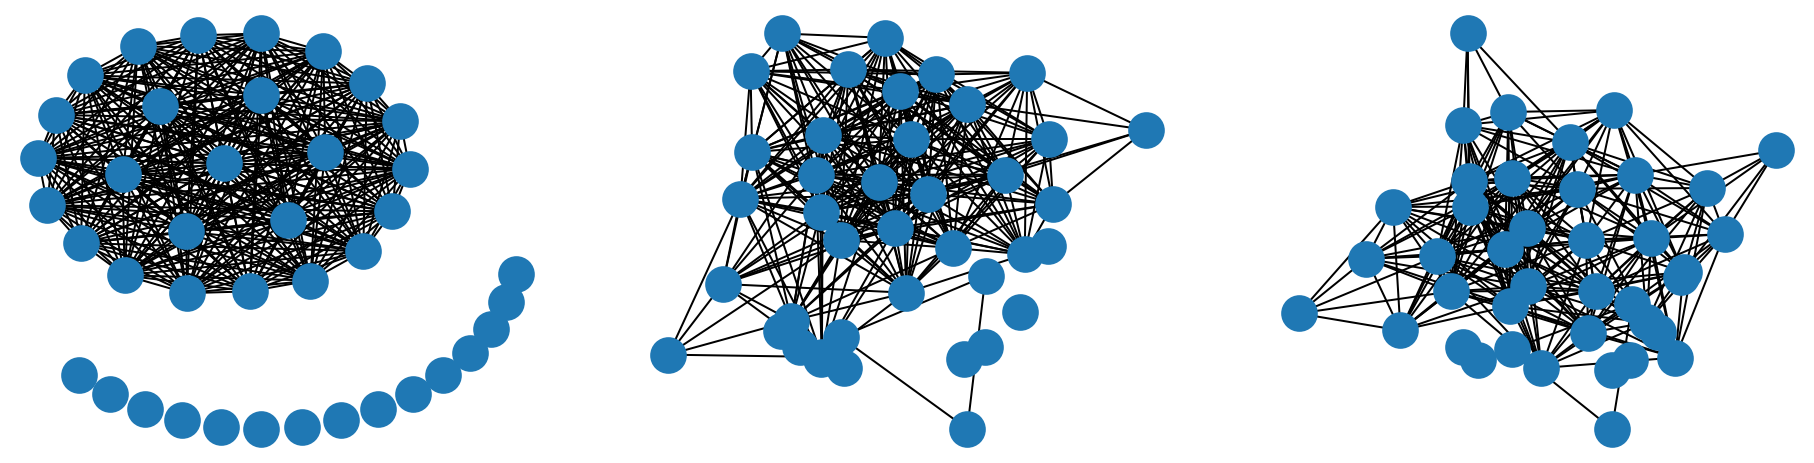

In [94]:
nums = [0, 7, 9]
fig = plt.figure(figsize=(16,4))
for i, n in enumerate(nums):
    plt.subplot(1, len(nums), i+1)
    nx.draw_kamada_kawai(IG_dict[2][n])

# Task path interference graph too 

In [13]:
def weighted_task_path_interference(g, p1, p2):
    if len(set(p1).intersection(set(p2)))>0:
        return True;
    count = 0;
    for l in range(len(p1)-1):
        if p2[l+1] in list(g.successors(p1[l])) or p1[l+1] in list(g.successors(p2[l])):
        	count+=1;
    return count;

In [19]:
def MP_task_interference_graph(graph, paths=None):
    return_paths = False;
    if paths==None:
        return_paths = True;
        mp_dict = nx.get_node_attributes(graph, 'subset');
        tot_units = np.sum(np.array(list(nx.get_node_attributes(graph, 'subset').values()))==0);
        vals = list(set(list(mp_dict.values())))
        min_set, max_set = np.min(vals), np.max(vals);
        output_nodes = [(max_set, x) for x in range(tot_units)]
        input_nodes = [(min_set, x) for x in range(tot_units)]
        paths = {}
        for n, nn in product(input_nodes, output_nodes):
            ps = list(nx.all_simple_paths(graph, n, nn));
            if len(ps)>0:
                paths[(n, nn)] = ps;
    node_path_list = []
    for k in paths:
        for kk in paths[k]:
            node_path_list.append(tuple(kk))
    ig = nx.Graph() # interference graph
    ig.add_nodes_from(node_path_list);
    for tf1, tf2 in combinations(node_path_list,2):
        w = weighted_task_path_interference(graph, tf1, tf2);
        if w>0:
            ig.add_edge(tf1, tf2, weight=w);
    if return_paths==True:
        return ig, paths;
    else:
        return ig;


In [20]:
MPT = MP_task_interference_graph(rew_MPG)

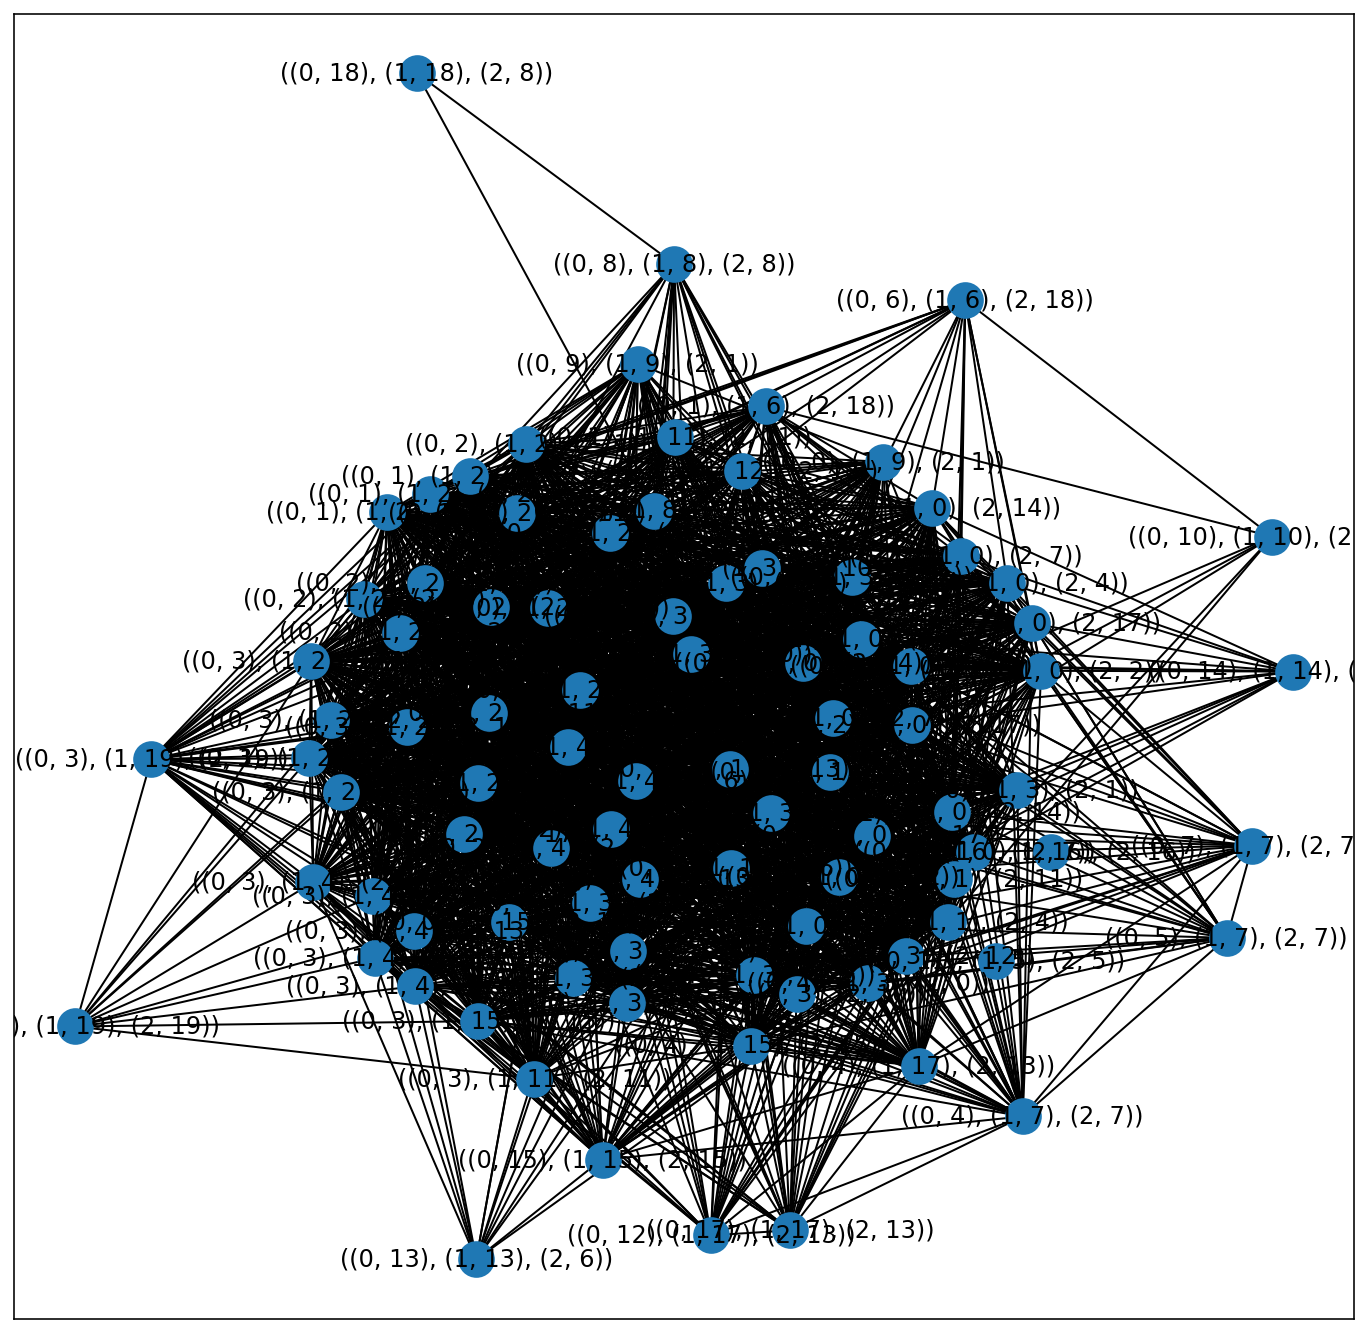

In [26]:
fig = plt.figure(figsize=(12,12))
pos_k = nx.kamada_kawai_layout(MPT[0])
nx.draw_networkx(MPT[0], pos=pos_k)

In [31]:
rew_IG = MP_interference_graph(rew_MPG)
len(nx.maximal_independent_set(MPT[0])), len(nx.maximal_independent_set(rew_IG[0]))

(8, 9)

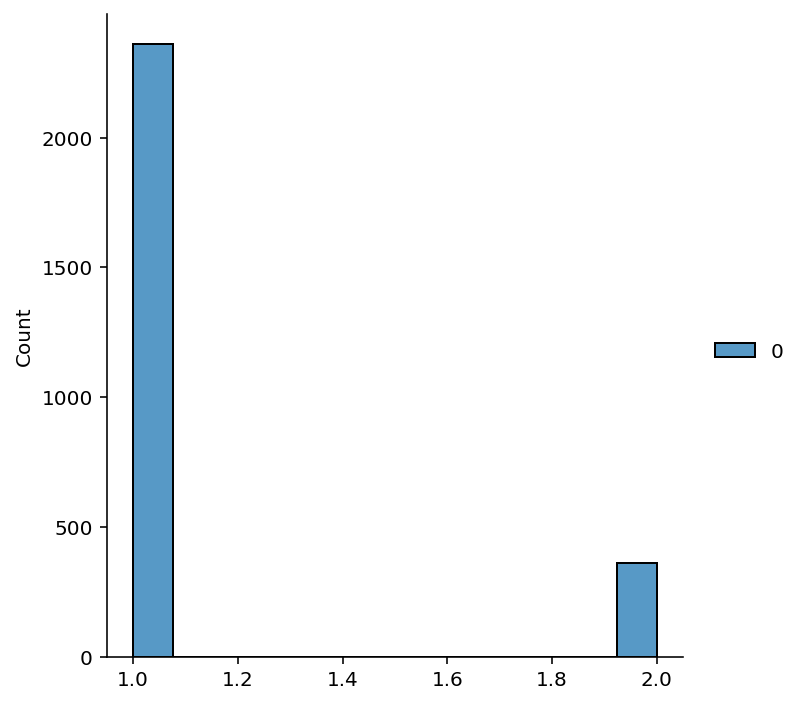

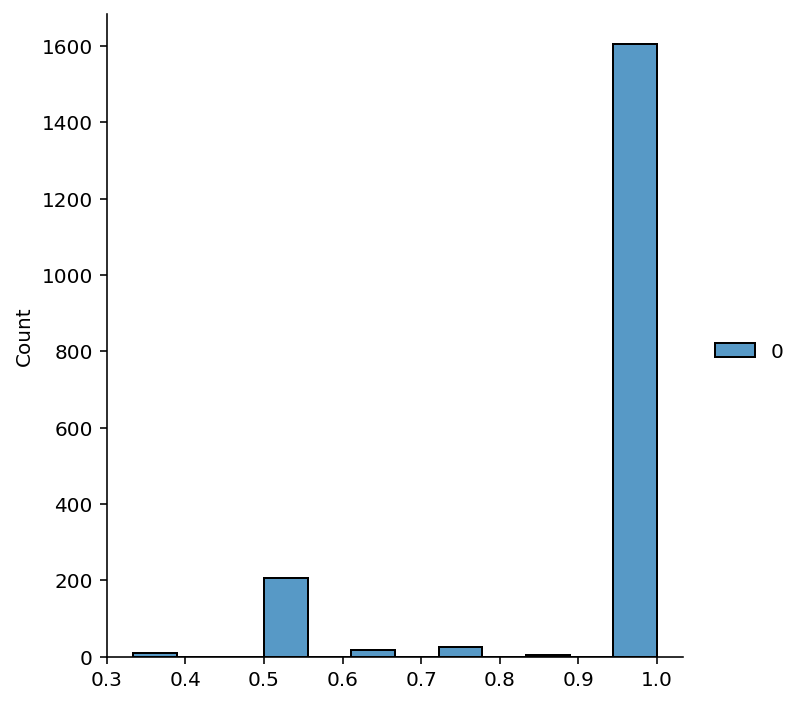

In [41]:
import seaborn as sns 
w = nx.get_edge_attributes(MPT[0], 'weight').values()
sns.displot(w)
w = nx.get_edge_attributes(rew_IG[0], 'weight').values()
sns.displot(w)


In [66]:
num_iterations = 10
rw_it = 0.1
IG_dict, tIG_dict = {}, {}

num_dense, num_sparse = 4, 12
tot_units = num_dense + num_sparse
density = 1
counts = {}
range_num_layers = [2, 3, 4, 5, 6]# 7, 8]
capacity = {}
independent_paths = {}

for nl in tqdm(range_num_layers):
    IG_dict[nl] = {}
    tIG_dict[nl] = {}
    tMPG = multipartite_network(nl, num_dense, num_sparse, density)    
    IG_dict[nl][0], instant_paths = MP_interference_graph(tMPG);
    instant_rew_MPG = tMPG.copy()
    counts[nl] = [0]
    for it in tqdm(range(1, num_iterations)):
        rw_it_num = int(instant_rew_MPG.number_of_edges() * rw_it) 
        instant_rew_MPG, instant_counts = rewire_multipartite_network(
            instant_rew_MPG, tot_units, rewire_prob=1, rewire_iters=rw_it_num, verbose=True)
        IG_dict[nl][it], instant_paths = MP_interference_graph(instant_rew_MPG)
        tIG_dict[nl][it] = MP_task_interference_graph(instant_rew_MPG, paths=instant_paths);
        


In [67]:
a, b = [], []
from scipy.stats import pearsonr, kendalltau
for nl in range_num_layers:
    al, bl = [], []
    for it in range(1, num_iterations):
        al.append(len(nx.maximal_independent_set(IG_dict[nl][it])))
        bl.append(len(nx.maximal_independent_set(tIG_dict[nl][it])))
    print(nl,  pearsonr(al, bl), kendalltau(al, bl))
    a.extend(al)
    b.extend(bl)
print('finale',  pearsonr(a, b), kendalltau(a, b))

2 (0.8588975014708021, 0.0030183985423001365) KendalltauResult(correlation=0.7499999999999999, pvalue=0.013697085790438622)
3 (0.8157607688097329, 0.007343583635980501) KendalltauResult(correlation=0.7302507302510953, pvalue=0.011200894871862358)
4 (0.7819777963135481, 0.012777910623612188) KendalltauResult(correlation=0.6866436491305119, pvalue=0.013758778624520556)
5 (0.8060544379296457, 0.008700739057232386) KendalltauResult(correlation=0.5336298767720561, pvalue=0.06945012152374609)
6 (0.5895661089853381, 0.09475890089554931) KendalltauResult(correlation=0.4064485096624696, pvalue=0.15545293255142464)
finale (0.8399754836782781, 5.469418021384707e-13) KendalltauResult(correlation=0.6934804165254801, pvalue=6.485673739231754e-10)
